In [1]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from category_encoders import OrdinalEncoder, OneHotEncoder, CatBoostEncoder

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('data/ggstore_train.csv', index_col='Id')

In [3]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated
Id,,,,,,,,,,,
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2018-01-07
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2018-01-15
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2018-08-01
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,Art & Design,2018-06-08
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,Art & Design;Creativity,2018-06-20


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5616 entries, 0 to 5615
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             5616 non-null   object 
 1   Category        5616 non-null   object 
 2   Rating          5616 non-null   float64
 3   Reviews         5616 non-null   int64  
 4   Size            5616 non-null   float64
 5   Installs        5616 non-null   float64
 6   Type            5616 non-null   int64  
 7   Price           5616 non-null   float64
 8   Content Rating  5616 non-null   object 
 9   Genres          5616 non-null   object 
 10  Last Updated    5616 non-null   object 
dtypes: float64(4), int64(2), object(5)
memory usage: 526.5+ KB


In [5]:
data.describe()

,Rating,Reviews,Size,Installs,Type,Price
count,5616.000000,5.616000e+03,5616.000000,5.616000e+03,5616.000000,5616.000000
mean,4.177386,1.686437e+05,21.831198,5.201445e+06,0.078526,1.409918
std,0.543153,1.126012e+06,22.744877,3.012485e+07,0.269021,20.341193
min,1.000000,1.000000e+00,0.008500,1.000000e+00,0.000000,0.000000
25%,4.000000,1.140000e+02,5.100000,1.000000e+04,0.000000,0.000000
50%,4.300000,2.158000e+03,13.000000,1.000000e+05,0.000000,0.000000
75%,4.500000,3.292125e+04,30.000000,1.000000e+06,0.000000,0.000000
max,5.000000,4.489172e+07,100.000000,1.000000e+09,1.000000,400.000000


# STEP 1. 결측치 확인

In [6]:
data.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
dtype: int64

결측치는 없다.

# STEP 2. Datetime column 처리

datetime으로부터 얼마나 오래전에 마지막 업데이트가 됐는지 파악한다.

In [7]:
def process_datetime(df):
    df['days_since_start'] = (pd.to_datetime(df['Last Updated']) - pd.to_datetime('2010-05-21')).dt.days.astype(np.float32)
    df = df.drop('Last Updated', axis=1)
    return df

In [8]:
data = process_datetime(data)

In [9]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,days_since_start
Id,,,,,,,,,,,
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,0,0.0,Everyone,Art & Design,2788.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,0,0.0,Everyone,Art & Design;Pretend Play,2796.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,0,0.0,Everyone,Art & Design,2994.0
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,0,0.0,Teen,Art & Design,2940.0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,0,0.0,Everyone,Art & Design;Creativity,2952.0


# STEP 3. 연속형 변수 이상치 탐색

In [10]:
continuous = ['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'days_since_start']

In [11]:
for col in continuous:
    display(data[col].nlargest(100).iloc[::10])

Id
224     5.0
879     5.0
1438    5.0
2584    5.0
3097    5.0
3171    5.0
3579    5.0
3829    5.0
3958    5.0
4122    5.0
Name: Rating, dtype: float64

Id
975     44891723
1094    10055521
1827     7790693
2226     5637451
1653     4865093
2304     4147718
242      3648120
1092     3057481
2291     2588730
4684     2233681
Name: Reviews, dtype: int64

Id
607     100.0
4602    100.0
1205     99.0
3288     99.0
2438     98.0
1384     97.0
2647     96.0
5583     96.0
2766     95.0
2367     94.0
Name: Size, dtype: float64

Id
960     1.000000e+09
149     1.000000e+08
968     1.000000e+08
988     1.000000e+08
1008    1.000000e+08
1120    1.000000e+08
1831    1.000000e+08
2208    1.000000e+08
2306    1.000000e+08
2671    1.000000e+08
Name: Installs, dtype: float64

Id
2510    400.00
3249    399.99
1339     29.99
3241     18.99
3997     14.99
1298     10.00
3841      9.99
1335      7.99
4612      6.99
3407      5.99
Name: Price, dtype: float64

Id
1874    3000.0
1501    2999.0
1736    2999.0
1890    2999.0
2126    2999.0
5280    2999.0
1159    2998.0
3118    2998.0
4345    2998.0
345     2997.0
Name: days_since_start, dtype: float32

Review에서 4천만개, 가격에서 400달러가 의심되지만, 불가능하지는 않다고 생각하여 이상치는 없다고 판단했다.

# STEP 4. App 처리

In [12]:
# 문자열 길이를 피쳐로 추가
data['len_App'] = data['App'].str.len()

App는 모든 값이 유니크하다. 많이 나오는 단어들을 살펴보자.

모든 단어들을 소문자로 바꾼 후 분석하겠다.

In [13]:
data['App'] = data['App'].apply(lambda x: x.lower().split())

In [14]:
def flatten(l):
    return [y for x in l for y in x]

corpus = flatten(data['App'].values)

In [15]:
counts = pd.Series(corpus).value_counts()

In [16]:
counts.head(10)

-         857
&         427
for       333
free      251
and       156
app       154
the       153
mobile    135
pro       116
by        106
dtype: int64

15번 이상 등장하는 단어들 중 2글자 이상인 것들만 고려하겠다. 이 단어들이 특정 샘플의 App 문자열에 포함되어있는지를 나타내는 dummy 변수를 만들겠다.

In [17]:
rel_words = [x for x in counts[counts>=15].index if len(x)>=2]
len(rel_words)

224

In [18]:
for c in rel_words:
    data[f'App_has_{c}'] = data['App'].apply(lambda x: c in x).astype(np.float32)
data = data.drop('App', axis=1)

# STEP 5. 범주형 변수 확인

각 범주형 열마다 빈도수 높은 10개, 낮은 10개, 유니크한 개수를 알아본다.

In [19]:
discrete = ['Category', 'Content Rating', 'Genres']
for col in discrete:
    display(data[col].value_counts().head(10))
    display(data[col].value_counts().tail(10))
    print(data[col].nunique())

FAMILY                1102
GAME                   657
TOOLS                  463
MEDICAL                253
PERSONALIZATION        227
LIFESTYLE              220
FINANCE                201
PHOTOGRAPHY            175
PRODUCTIVITY           173
HEALTH_AND_FITNESS     172
Name: Category, dtype: int64

ENTERTAINMENT         64
LIBRARIES_AND_DEMO    57
ART_AND_DESIGN        57
AUTO_AND_VEHICLES     55
HOUSE_AND_HOME        48
COMICS                46
PARENTING             43
WEATHER               37
EVENTS                34
BEAUTY                34
Name: Category, dtype: int64

33


Everyone           4531
Teen                589
Mature 17+          281
Everyone 10+        212
Adults only 18+       2
Unrated               1
Name: Content Rating, dtype: int64

Everyone           4531
Teen                589
Mature 17+          281
Everyone 10+        212
Adults only 18+       2
Unrated               1
Name: Content Rating, dtype: int64

6


Tools              463
Entertainment      337
Education          309
Medical            253
Personalization    227
Lifestyle          219
Action             214
Finance            201
Photography        175
Productivity       173
Name: Genres, dtype: int64

Education;Brain Games                    1
Comics;Creativity                        1
Books & Reference;Education              1
Simulation;Education                     1
Entertainment;Pretend Play               1
Health & Fitness;Education               1
Health & Fitness;Action & Adventure      1
Lifestyle;Pretend Play                   1
Video Players & Editors;Music & Video    1
Board;Pretend Play                       1
Name: Genres, dtype: int64

106


매우 적게 등장하는 값들이 많이 존재한다. 5번 이하로 등장하는 값들은 `_OTHERS`로 바꿔준다.

In [20]:
for col in discrete:
    val_counts = data[col].value_counts()
    data[col] = data[col].apply(lambda x: x if val_counts.loc[x] > 5 else '_OTHERS')

각 column별 유니크한 값들을 저장해둔다. 나중에 test의 값들 중 저장된 값들에 포함되지 않는 값들은 `_OTHERS`로 치환할 것이다.

In [21]:
unique_values = {col: data[col].unique() for col in discrete}

# STEP 6. Feature Engineering

In [22]:
# Price가 이미 Type 정보를 포함하고 있으므로 Type은 제거한다
data = data.drop('Type', axis=1)

In [23]:
# 인스톨 수 당 리뷰 개수를 추가
data['review_per_install'] = data['Reviews'] / data['Installs']

In [24]:
main_features = ['Reviews', 'Installs', 'review_per_install']
category_means = {}
genre_means = {}
year_means = {}
cr_means = {}
data['years_since_start'] = data['days_since_start']//365
# 같은 분류에 들어가 있는 샘플들의 main_feature의 평균을 구하고 이와의 비율을 계산
for feat in main_features:
    category_means[feat] = data.groupby('Category')[feat].mean()
    data[f'{feat}_in_category_ratio'] = data[feat] / data['Category'].map(category_means[feat])
    genre_means[feat] = data.groupby('Genres')[feat].mean()
    data[f'{feat}_in_genre_ratio'] = data[feat] / data['Genres'].map(genre_means[feat])
    year_means[feat] = data.groupby('years_since_start')[feat].mean()
    data[f'{feat}_in_years_ratio'] = data[feat] / data['years_since_start'].map(year_means[feat])
    cr_means[feat] = data.groupby('Content Rating')[feat].mean()
    data[f'{feat}_in_cr_ratio'] = data[feat] / data['Content Rating'].map(cr_means[feat])
data = data.drop('years_since_start', axis=1)

In [25]:
data.head()

,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,days_since_start,len_App,App_has_for,App_has_free,App_has_and,App_has_app,App_has_the,App_has_mobile,App_has_pro,App_has_by,App_has_of,App_has_video,App_has_live,App_has_2018,App_has_photo,App_has_my,App_has_chat,App_has_theme,App_has_to,App_has_game,App_has_news,App_has_camera,App_has_editor,App_has_dating,App_has_3d,App_has_tracker,App_has_simulator,App_has_calculator,App_has_online,App_has_launcher,App_has_in,App_has_with,App_has_hd,App_has_learn,App_has_manager,App_has_remote,App_has_android,App_has_tv,App_has_wallpaper,App_has_car,App_has_games,App_has_kids,App_has_maker,App_has_number,App_has_cv,App_has_color,App_has_english,App_has_baby,App_has_go,App_has_text,App_has_bd,App_has_keyboard,App_has_screen,App_has_best,App_has_dp,App_has_wallpapers,App_has_book,App_has_ac,App_has_at,App_has_browser,App_has_all,App_has_cg,App_has_call,App_has_weather,App_has_super,App_has_coloring,App_has_am,App_has_ap,App_has_resume,App_has_real,App_has_world,App_has_pack,App_has_ct,App_has_bt,App_has_player,App_has_on,App_has_blood,App_has_control,App_has_db,App_has_your,App_has_gps,App_has_ae,App_has_smart,App_has_love,App_has_dr.,App_has_cm,App_has_be,App_has_test,App_has_cp,App_has_art,App_has_dc,App_has_phone,App_has_city,App_has_lite,App_has_banking,App_has_new,App_has_cr,App_has_au,App_has_bc,App_has_cu,App_has_cb,App_has_pixel,App_has_ar,App_has_bn,App_has_reader,App_has_shopping,App_has_guide,App_has_search,App_has_easy,App_has_status,App_has_selfie,App_has_offline,App_has_bank,App_has_nights,App_has_ai,App_has_sports,App_has_food,App_has_download,App_has_lock,App_has_beauty,App_has_builder,App_has_pressure,App_has_dm,App_has_virtual,App_has_fast,App_has_fun,App_has_ag,App_has_draw,App_has_dragon,App_has_step,App_has_az,App_has_music,App_has_videos,App_has_dg,App_has_daily,App_has_ba,App_has_recorder,App_has_file,App_has_rich,App_has_plus,App_has_survival,App_has_meet,App_has_bl,App_has_time,App_has_radio,App_has_racing,App_has_ab,App_has_icon,App_has_ideas,App_has_vpn,App_has_do,App_has_block,App_has_map,App_has_cs,App_has_king,App_has_bw,App_has_widget,App_has_pocket,App_has_aj,App_has_ad,App_has_auto,App_has_black,App_has_bk,App_has_clock,App_has_war,App_has_av,App_has_day,App_has_puzzle,App_has_downloader,App_has_ultimate,App_has_bg,App_has_practice,App_has_heroes,App_has_ce,App_has_math,App_has_cw,App_has_workout,App_has_girls,App_has_home,App_has_dk,App_has_counter,App_has_classic,App_has_bp,App_has_bf,App_has_premium,App_has_dictionary,App_has_find,App_has_five,App_has_quest,App_has_al,App_has_scanner,App_has_life,App_has_truck,App_has_manga,App_has_bi,App_has_driving,App_has_royale,App_has_cf,App_has_quran,App_has_traffic,App_has_makeup,App_has_adventure,App_has_fantasy,App_has_bz,App_has_morse,App_has_battle,App_has_prep,App_has_health,App_has_play,App_has_recipes,App_has_whatsapp,App_has_official,App_has_read,App_has_fitness,App_has_list,App_has_cars,App_has_cs:go,App_has_cl,App_has_shop,App_has_parking,App_has_comics,App_has_ci,App_has_style,App_has_wifi,App_has_zombie,App_has_google,review_per_install,Reviews_in_category_ratio,Reviews_in_genre_ratio,Reviews_in_years_ratio,Reviews_in_cr_ratio,Installs_in_category_ratio,Installs_in_genre_ratio,Installs_in_years_ratio,Installs_in_cr_ratio,review_per_install_in_category_ratio,review_per_install_in_genre_ratio,review_per_install_in_years_ratio,review_per_install_in_cr_ratio
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,ART_AND_DESIGN,4.1,159,19.0,10000.0,0.0,Everyone,Art & Design,2788.0,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

# STEP 7. Category Encoding

간단한 label encoding (ordinal encoding)을 통해 gbm 모델이 처리할 수 있도록 한다. ridge 및 svm에 넣을 때는 one hot을 추후에 해줄 것이다.

In [26]:
cat_enc = OrdinalEncoder()
data[discrete] = cat_enc.fit_transform(data[discrete]).astype(np.float32)

In [27]:
data.head()

,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,days_since_start,len_App,App_has_for,App_has_free,App_has_and,App_has_app,App_has_the,App_has_mobile,App_has_pro,App_has_by,App_has_of,App_has_video,App_has_live,App_has_2018,App_has_photo,App_has_my,App_has_chat,App_has_theme,App_has_to,App_has_game,App_has_news,App_has_camera,App_has_editor,App_has_dating,App_has_3d,App_has_tracker,App_has_simulator,App_has_calculator,App_has_online,App_has_launcher,App_has_in,App_has_with,App_has_hd,App_has_learn,App_has_manager,App_has_remote,App_has_android,App_has_tv,App_has_wallpaper,App_has_car,App_has_games,App_has_kids,App_has_maker,App_has_number,App_has_cv,App_has_color,App_has_english,App_has_baby,App_has_go,App_has_text,App_has_bd,App_has_keyboard,App_has_screen,App_has_best,App_has_dp,App_has_wallpapers,App_has_book,App_has_ac,App_has_at,App_has_browser,App_has_all,App_has_cg,App_has_call,App_has_weather,App_has_super,App_has_coloring,App_has_am,App_has_ap,App_has_resume,App_has_real,App_has_world,App_has_pack,App_has_ct,App_has_bt,App_has_player,App_has_on,App_has_blood,App_has_control,App_has_db,App_has_your,App_has_gps,App_has_ae,App_has_smart,App_has_love,App_has_dr.,App_has_cm,App_has_be,App_has_test,App_has_cp,App_has_art,App_has_dc,App_has_phone,App_has_city,App_has_lite,App_has_banking,App_has_new,App_has_cr,App_has_au,App_has_bc,App_has_cu,App_has_cb,App_has_pixel,App_has_ar,App_has_bn,App_has_reader,App_has_shopping,App_has_guide,App_has_search,App_has_easy,App_has_status,App_has_selfie,App_has_offline,App_has_bank,App_has_nights,App_has_ai,App_has_sports,App_has_food,App_has_download,App_has_lock,App_has_beauty,App_has_builder,App_has_pressure,App_has_dm,App_has_virtual,App_has_fast,App_has_fun,App_has_ag,App_has_draw,App_has_dragon,App_has_step,App_has_az,App_has_music,App_has_videos,App_has_dg,App_has_daily,App_has_ba,App_has_recorder,App_has_file,App_has_rich,App_has_plus,App_has_survival,App_has_meet,App_has_bl,App_has_time,App_has_radio,App_has_racing,App_has_ab,App_has_icon,App_has_ideas,App_has_vpn,App_has_do,App_has_block,App_has_map,App_has_cs,App_has_king,App_has_bw,App_has_widget,App_has_pocket,App_has_aj,App_has_ad,App_has_auto,App_has_black,App_has_bk,App_has_clock,App_has_war,App_has_av,App_has_day,App_has_puzzle,App_has_downloader,App_has_ultimate,App_has_bg,App_has_practice,App_has_heroes,App_has_ce,App_has_math,App_has_cw,App_has_workout,App_has_girls,App_has_home,App_has_dk,App_has_counter,App_has_classic,App_has_bp,App_has_bf,App_has_premium,App_has_dictionary,App_has_find,App_has_five,App_has_quest,App_has_al,App_has_scanner,App_has_life,App_has_truck,App_has_manga,App_has_bi,App_has_driving,App_has_royale,App_has_cf,App_has_quran,App_has_traffic,App_has_makeup,App_has_adventure,App_has_fantasy,App_has_bz,App_has_morse,App_has_battle,App_has_prep,App_has_health,App_has_play,App_has_recipes,App_has_whatsapp,App_has_official,App_has_read,App_has_fitness,App_has_list,App_has_cars,App_has_cs:go,App_has_cl,App_has_shop,App_has_parking,App_has_comics,App_has_ci,App_has_style,App_has_wifi,App_has_zombie,App_has_google,review_per_install,Reviews_in_category_ratio,Reviews_in_genre_ratio,Reviews_in_years_ratio,Reviews_in_cr_ratio,Installs_in_category_ratio,Installs_in_genre_ratio,Installs_in_years_ratio,Installs_in_cr_ratio,review_per_install_in_category_ratio,review_per_install_in_genre_ratio,review_per_install_in_years_ratio,review_per_install_in_cr_ratio
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,4.1,159,19.0,10000.0,0.0,1.0,1.0,2788.0,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# STEP 8. X와 y로 분리

In [28]:
x_data = data.drop('Rating', axis=1)
y_data = data['Rating'].astype(np.float32)

svm 및 lr을 fit할 때 사용하게 될 robust scaler와 onehot encoder을 fit해준다.

In [29]:
scl = RobustScaler()
scl = scl.fit(x_data.drop(discrete, axis=1))
ohe = OneHotEncoder()
ohe = ohe.fit(x_data[discrete].astype(str))

# STEP 9. Hyperparameter Search

* hyperparameter search를 위해 grid search나 random search보다 빠르다고 알려진 optuna 라이브러리를 사용했다. (https://optuna.org/)
* ridge나 svm을 돌릴 때는 discrete 열들은 one hot encoding 하였다. 또 robust scaler을 활용해 스케일링했다. gbm은 tree 기반 알고리즘이므로 xgb나 lgb를 돌릴 때에는 discrete 열들은 label encoding해둔 상태로 놔뒀고, scaling도 하지 않았다.
* lgbm 2개, xgb 2개, catboost 2개, random forest 1개, ridge 1개, linear svr 1개를 대상으로 진행

In [30]:
# rmse metric 정의
def rmse(y_pred, y_true):
    return np.sqrt(np.mean((y_true-y_pred)**2))

# ridge나 svm 돌릴 때는 카테고리 변수 onehot하고 연속변수 scaling
def onehot_scale(x):
    x = x.copy()
    discrete_df = ohe.transform(x[discrete].astype(str))
    continuous_df = x.drop(discrete, axis=1)
    continuous_df = pd.DataFrame(scl.transform(continuous_df), index=continuous_df.index, columns=continuous_df.columns)
    return pd.concat([discrete_df, continuous_df], axis=1)

# n fold cv (각 fold마다 모델 하나씩 train)
# oof pred는 각 fold의 validation 예측값들을 모아놓은 것이다. 따라서 전체 데이터에 대한 예측값들로 구성된다.
def oof(x_data, y_data, params, nfolds=5, x_test=None, algo='lgb'):
    
    if algo in ['ridge', 'svr']:
        x_data = onehot_scale(x_data)
        if x_test is not None:
            x_test = onehot_scale(x_test)
   
    
    folds = list(KFold(nfolds, shuffle=True, random_state=0).split(data))
    
    models = []
    oof_pred = np.zeros(len(x_data))
    if x_test is not None:
        x_test = x_test.values
        test_pred = np.zeros(len(x_test))
    
    for trn_idx, val_idx in folds:
        x_trn = x_data.iloc[trn_idx].values
        x_val = x_data.iloc[val_idx].values
        y_trn = y_data.iloc[trn_idx].values
        y_val = y_data.iloc[val_idx].values
        if algo == 'lgb':
            model = LGBMRegressor(**params)
            model = model.fit(x_trn, y_trn, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=None)
        elif algo == 'xgb':
            model = XGBRegressor(**params)
            model = model.fit(x_trn, y_trn, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=None)
        elif algo == 'cb':
            model = CatBoostRegressor(**params)
            model = model.fit(x_trn, y_trn, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=None, silent=True)
        elif algo == 'ridge':
            model = Ridge(**params)
            model = model.fit(x_trn, y_trn)
        elif algo == 'svr':
            model = LinearSVR(**params)
            model = model.fit(x_trn, y_trn)
        oof_pred[val_idx] = model.predict(x_val)
        models.append(model)
        if x_test is not None:
            test_pred += model.predict(x_test) / 5
    
    oof_score = rmse(oof_pred, y_data)
    print(oof_score)
    
    if x_test is None:
        return models, oof_pred, oof_score
    else:
        return models, oof_pred, oof_score, test_pred

## 1. XGBoost (1)

In [31]:
# objective을 정해주면 이를 최소화하는 방식으로 optuna가 hyperparameter search를 한다.
def objective_xgb(trial):
    
    # 각 모델의 주요 파라미터들의 search 범위를 정해준다.
    params = {
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_uniform('eta', 0.03, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'subsample': trial.suggest_uniform('subsample', 1e-8, 1.0),  # 1.0
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 1e-8, 1.0),  # 1.0
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 1e-8, 1.0),  # 1.0
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 150.0),  # 1.0
        'max_bin': trial.suggest_int('max_bin', 63, 256),  # 256
        'predictor': 'cpu_predictor',
        'nthread': 8,
        'objective': 'reg:squarederror',
        'n_estimators': 100000,
        'seed': 0
    }
    
    models, oof_pred, oof_score = oof(x_data, y_data, params, nfolds=5, x_test=None, algo='xgb')
    return oof_score

In [32]:
xgb_study = optuna.create_study()
xgb_study.optimize(objective_xgb, timeout=600, n_jobs=1)
print(xgb_study.best_params, xgb_study.best_value)

0.5537897821325364
0.5924112127846981
0.4987302864290276
0.5036880391219419
0.519196525679722
0.5012032191383977
0.5119884041781277
0.5156051500418228
0.5309261661454954
0.5122682366071737
0.5429843679102626
0.4948487457852803
0.4926140514417568
0.49630069641973534
0.4990733115961333
0.5000298556768079
0.4939337052166387
0.48969502340511045
0.5104835513503847
0.4924173986214629
0.4980369960207973
0.49101061154297104
0.4916690970976558
0.5019422113614307
0.4934031425786103
0.5145618814845709
0.5081712283015571
0.49180081231486017
0.5034503724566923
0.540050072682345
0.5438737963455998
0.4941970837308
0.4904568826186384
0.4943706086712855
0.49110668578400873
0.4978254366601221
0.4947812877624866
0.4967808358771789
0.49100791298788693
0.5047332543675846
0.5109677873211548
0.4925757652269693
0.4900882350769968
0.48919158082371156
0.4897758031162155
0.4972882353751274
0.4902360030325331
0.49871564200723645
0.49262651467097424
0.4894304224121464
0.4896675527524787
0.4893442818928612
0.491204

In [33]:
# 가장 rmse가 낮게 나온 xgb_params 정의
xgb_params = xgb_study.best_params.copy()
xgb_params['predictor'] = 'cpu_predictor'
xgb_params['nthread'] = 8
xgb_params['objective'] = 'reg:squarederror'
xgb_params['n_estimators'] = 100000

## 2. XGBoost (2)

In [34]:
xgb2_study = optuna.create_study()
xgb2_study.optimize(objective_xgb, timeout=600, n_jobs=1)
print(xgb2_study.best_params, xgb2_study.best_value)

0.5043848085653175
0.5061166883078649
0.5134665586341216
0.6153532787562317
0.5964114350297177
0.5500835107134893
0.5035647013047196
0.6426440456595384
0.4914776552505951
0.5624164069710986
0.48941754721617536
0.4877145806762851
0.4904842195331927
0.5027204434395441
0.5050092580963889
0.49498432360915096
0.5037749437497471
0.5016768115228235
0.4919335010651507
0.4949927902436783
0.496486793777375
0.5014524545639469
0.49806863375493826
0.49299250639588504
0.4961960409588414
0.5143039849274944
0.4902950194175264
0.4964953284733795
0.5314812625709012
0.5313735479989672
0.5078178429610735
0.5013453661410524
0.5080587049323899
0.5004023882060409
0.4901371249750066
0.49068358329026485
0.4947163381457214
0.494752264722398
0.4922773745743161
0.4963141317073544
0.49244051350542944
0.48958182210081774
0.4913786133708868
0.49327244113797375
0.4938066408401708
0.49194490053286505
0.4939832024478935
0.4902849888264982
0.4952950860122278
0.49815487062019786
0.5031377776374838
0.4873321987410265
0.48

In [35]:
xgb2_params = xgb2_study.best_params.copy()
xgb2_params['predictor'] = 'cpu_predictor'
xgb2_params['nthread'] = 8
xgb2_params['objective'] = 'reg:squarederror'
xgb2_params['n_estimators'] = 100000

## 3. LightGBM (1)

In [36]:
def objective_lgb(trial, x_data, y_data):
    
    params = {
        'num_leaves': int(trial.suggest_loguniform('num_leaves', 2, 2**9)),  # 31
        'max_depth': trial.suggest_int('max_depth', 1, 100), # -1
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),  # 20
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 150.0),  # 1e-3
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),  # 0.0
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),  # 0.0
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),  # 0.0
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # 1.0
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 15000, 40000),  # 20000
        'boost_from_average': trial.suggest_categorical('boost_from_average', [True, False]),  # True
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),  # 1.0
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),  # 0
        'max_bin': trial.suggest_int('max_bin', 63, 255),  # 255
        'seed': 0,
        'device_type': 'cpu',
        'n_jobs': 8,
        'objective': 'regression',
        'num_iterations': 100000,
        'metric': 'rmse',
        'importance_type': 'gain'
    }
    
    models, oof_pred, oof_score = oof(x_data, y_data, params, nfolds=5, x_test=None, algo='lgb')

    return oof_score

In [37]:
lgb_study = optuna.create_study()
lgb_study.optimize(lambda x: objective_lgb(x, x_data, y_data), timeout=600, n_jobs=1)
print(lgb_study.best_params, lgb_study.best_value)

0.49297789082402405
0.49778538694891483
0.4943577737999742
0.4971644441021248
0.49144543932996126
0.4969632015591297
0.4915666211754865
0.4935419853328166
0.49153099692107904
0.49647549549410436
0.4924818889861123
0.49814359670764824
0.49154036388951927
0.50309971940329
0.4963060823406734
0.4929937318004593
2.6867261536328124
0.4905168701766132
0.4918988536494231
0.49007959046927113
0.4898973680521097
0.4899059022973613
0.4904788505589474
0.48929674751994
0.4900201386858249
0.4905486030970438
0.49038703617512674
0.4898469264026254
0.48990477197167936
0.49052469443471103
0.4894244394342512
0.4889622373158875
0.4899950913485107
0.4900216861539626
0.4901020460790329
0.49136424724820627
0.4897593629995334
0.49090633209572004
0.49074283457861706
0.490305198230016
0.4907391091776692
0.4901410508039148
0.49039684374548487
0.4893907831296905
0.49045818466060326
0.49099408153294427
0.49005689061047697
0.4899490799876774
0.4901674618790396
0.49122095507785785
0.49177033120432284
0.48999589606064

In [38]:
lgb_params = lgb_study.best_params.copy()
lgb_params['num_leaves'] = int(lgb_params['num_leaves'])
lgb_params['device_type'] = 'cpu'
lgb_params['n_jobs'] = 8
lgb_params['objective'] = 'regression'
lgb_params['num_iterations'] = 100000
lgb_params['metric'] = 'rmse'
lgb_params['importance_type'] = 'gain'

## 4. LightGBM (2)

In [39]:
lgb2_study = optuna.create_study()
lgb2_study.optimize(lambda x: objective_lgb(x, x_data, y_data), timeout=600, n_jobs=1)
print(lgb2_study.best_params, lgb2_study.best_value)

0.5063561308667117
0.4932157654752779
0.4955524082802059
0.49355702108699884
0.49031727775702166
0.4955657555063997
0.4899966904507716
0.49346050222912535
0.49688488780945994
0.4905088634672734
0.4911302450011328
0.48990396845956785
0.48980622304554805
0.48961412079776034
0.4898954422049976
0.49053332990890386
0.48955810696896157
0.4904048545778256
0.4926735172367172
0.48929794564519496
0.49121604485574727
0.49208156903957206
0.49109799199387744
0.49297253292598436
0.4891435381392617
0.4915103149800294
0.49180075822543134
0.49012447430719086
0.4931116969552845
0.4959683387562926
0.4935741043655396
0.4899987211166612
0.4940117587430382
0.4916824350039515
0.49134927447795573
0.4925564569042774
0.48903121336426036
0.490964527830511
0.4931582057067402
0.4910339458955028
0.4915929071397108
0.48964482840654194
0.4898390604681452
0.4896621337293319
0.4930038306711121
0.4906926700899053
0.49036695151952653
1.9277064626321705
0.49495545453383527
0.49160057031675075
0.49063521957941425
0.4900907

In [40]:
lgb2_params = lgb2_study.best_params.copy()
lgb2_params['num_leaves'] = int(lgb2_params['num_leaves'])
lgb2_params['device_type'] = 'cpu'
lgb2_params['n_jobs'] = 8
lgb2_params['objective'] = 'regression'
lgb2_params['num_iterations'] = 100000
lgb2_params['metric'] = 'rmse'
lgb2_params['importance_type'] = 'gain'

## 5. CatBoost (1)

In [41]:
def objective_cb(trial, x_data, y_data):
    
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.003, 0.3),
        'depth': trial.suggest_int('depth', 1, 8),  # 6, up to 8 if gpu
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),  # 3
        'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 10.0),  # 1
        'border_count': trial.suggest_int('border_count', 63, 254),  # 254
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'Bayesian']),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'random_seed': 0,
        'task_type': 'CPU',
        'thread_count': 8,
        'loss_function': 'RMSE',
        'iterations': 100000,
        'allow_writing_files': False,
    }
    
    if params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_uniform('subsample', 1e-8, 1.0)  # 0.66
    else:
        params['bagging_temperature'] = trial.suggest_uniform('bagging_temperature', 0.0, 5.0)  # 1
        
    models, oof_pred, oof_score = oof(x_data, y_data, params, nfolds=5, x_test=None, algo='cb')

    return oof_score

In [65]:
cb_study = optuna.create_study()
cb_study.optimize(lambda x: objective_cb(x, x_data, y_data), timeout=600, n_jobs=1)
print(cb_study.best_params, cb_study.best_value)

0.48880443221458175
0.4906079272612535
0.4888371832925
0.48873963490858474
0.48863612297265446
0.49153073455547036
0.4923823241968547
0.4875997173872547
0.4884479358076268
0.4885067556296611
0.48728766165458004
0.487932756094185
0.4919448034948292
0.48774163363999995
0.48744027134454415
0.4914170716857586
0.488119488592515
0.489356215462676
0.49032381932861785
0.4868791281331052
0.48800076751837634
0.48951796196356184
0.48973674083328766
0.48868635288373297
0.49283269410169855
0.48866840883882295
0.4882941258046121
0.48808065343721396
0.4900819471232307
0.486809392045374
0.48677849242084564
0.48780285773887294
0.48794141552965964
0.4891295408052022
0.49126997541713574
0.49125467190305566
0.49152059834173184
0.48848051598355335
{'learning_rate': 0.19127781909170932, 'depth': 6, 'l2_leaf_reg': 7, 'random_strength': 9.065043032955721, 'border_count': 233, 'bootstrap_type': 'Bernoulli', 'boosting_type': 'Ordered', 'subsample': 0.9426352150930448} 0.48677849242084564


In [66]:
cb_params = cb_study.best_params.copy()
cb_params['task_type'] = 'CPU'
cb_params['thread_count'] = 8
cb_params['loss_function'] = 'RMSE'
cb_params['iterations'] = 100000
cb_params['allow_writing_files'] = False

## 6. CatBoost (2)

In [45]:
cb2_study = optuna.create_study()
cb2_study.optimize(lambda x: objective_cb(x, x_data, y_data), timeout=600, n_jobs=1)
print(cb2_study.best_params, cb2_study.best_value)

0.49914789371216134
0.4892503711223118
0.4867959035866931
0.48847161103168807
0.48525664701799787
0.4870126584738819
0.48873578772670023
0.4889320164047062
0.4896441305572035
0.4876635283450577
0.48743267043283545
0.48874680412428556
0.48980713793983566
0.4881994369267787
0.4882164980427342
0.48840459104269457
0.48908713698094247
0.4904809692578776
0.49047180722393385
0.4877065564321409
0.48790324118176903
0.4874267749936528
0.48934392837421814
0.48683640495204855
0.48642922931267474
0.4875756206957894
0.4853549314722554
0.4873337324469417
0.487128766537775
0.48797861700043227
{'learning_rate': 0.10986286963284618, 'depth': 7, 'l2_leaf_reg': 8, 'random_strength': 6.935744354600565, 'border_count': 76, 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'bagging_temperature': 0.02703182373986933} 0.48525664701799787


In [46]:
cb2_params = cb2_study.best_params.copy()
cb2_params['task_type'] = 'CPU'
cb2_params['thread_count'] = 8
cb2_params['loss_function'] = 'RMSE'
cb2_params['iterations'] = 100000
cb2_params['allow_writing_files'] = False

## 7. LightGBM RandomForest

In [47]:
def objective_rf(trial):
    
    params = {
        'num_leaves': int(trial.suggest_loguniform('num_leaves', 2, 2**9)),  # 31
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),  # 20
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 150.0),  # 1e-3
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),  # 0.0
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),  # 0.0
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),  # 0.0
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),  # 1.0
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 15000, 40000),  # 20000
        'boost_from_average': trial.suggest_categorical('boost_from_average', [True, False]),  # True
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),  # 1.0
        'max_bin': trial.suggest_int('max_bin', 63, 255),  # 255
        'subsample_freq': 1,  # 0
        'boosting_type': 'rf',
        'seed': 0,
        'device_type': 'cpu',
        'n_jobs': 8,
        'objective': 'regression',
        'num_iterations': 100000,
        'metric': 'rmse',
        'importance_type': 'gain'
    }
    
    models, oof_pred, oof_score = oof(x_data, y_data, params, nfolds=5, x_test=None, algo='lgb')

    return oof_score

In [48]:
rf_study = optuna.create_study()
rf_study.optimize(objective_rf, timeout=400, n_jobs=1)
print(rf_study.best_params, rf_study.best_value)

0.5016964397530386
0.5163795891341676
0.5118893405589228
0.4999256369426847
0.5011322025827273
0.5133281003394284
0.510246962487789
0.5134414052269259
0.5071133149022664
0.5118490273952051
0.4999494012464439
0.5023553127774592
0.5004859190052593
0.5005058837906384
0.5192590375246365
0.4986848519040652
0.49940390843263505
0.4990494754945842
0.4997074301373427
0.49847749512377854
0.4978066829516341
0.4980230457282485
0.4970783776269222
0.49636232087549925
0.49599219754491397
0.49612911589626085
0.4958622389960254
0.49519127158826765
0.50098623056829
0.498055658274549
0.4944838923171625
0.4940934106019953
0.49413396047932195
0.4946209264525945
0.5046094855074884
0.4994589505870277
0.4945412037266726
0.5080706978986178
0.4953482427594172
0.4942219024516398
0.5102325567727192
0.49657899406270983
0.4973890333413671
0.5013322776310539
0.5005642909413018
0.49991127603628627
0.5001453072532908
0.4971225926556315
0.4966503725544846
0.49635564860822134
0.5052512046194682
0.49441697165042114
0.496

In [49]:
rf_params = rf_study.best_params.copy()
rf_params['num_leaves'] = int(rf_params['num_leaves'])
rf_params['device_type'] = 'cpu'
rf_params['n_jobs'] = 8
rf_params['objective'] = 'regression'
rf_params['num_iterations'] = 100000
rf_params['metric'] = 'rmse'
rf_params['importance_type'] = 'gain'
rf_params['subsample_freq'] = 1
rf_params['boosting_type'] = 'rf'

## 8. Ridge

In [50]:
def objective_ridge(trial):
    
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1000)
    }
    
    models, oof_pred, oof_score = oof(x_data, y_data, params, nfolds=5, x_test=None, algo='ridge')

    return oof_score

In [51]:
ridge_study = optuna.create_study()
ridge_study.optimize(objective_ridge, timeout=10, n_jobs=1)
print(ridge_study.best_params, ridge_study.best_value)

0.5085542730867187
0.511599316424368
0.5116271982620599
0.5037556037748735
0.511627197811472
0.5116242667862269
0.5116223277469264
0.5114994834517155
0.5069791796290263
0.5116271982636444
0.5075882828504265
0.5158264723518462
0.5047005144596572
0.5037444759445616
0.5116271572036464
0.5166423902147405
0.5110050080179471
0.5044707850996233
0.5100274191414513
0.5107655357284855
0.511626285921149
0.5037824396718511
0.503728656416942
0.5109012796688394
0.5127606455895591
0.5068864819927319
0.5046106031861195
0.5115213554296137
0.511627047755584
0.5095318104176544
0.5038975032400655
0.5039438046160812
0.5086824115565821
0.5069100926510552
0.5043961127385721
0.5115481871999015
0.5168844515574583
0.5097745174981994
0.5070991869689139
0.511312706473558
0.5116088878980645
{'alpha': 17.212121930588932} 0.503728656416942


In [52]:
ridge_params = ridge_study.best_params.copy()

## 9. LinearSVR

In [53]:
def objective_svr(trial):
    
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 0.1),
        'random_state': 0,
        'max_iter': 1000000
    }
    
    models, oof_pred, oof_score = oof(x_data, y_data, params, nfolds=5, x_test=None, algo='svr')

    return oof_score

In [54]:
svr_study = optuna.create_study()
svr_study.optimize(objective_svr, timeout=120, n_jobs=8)
print(svr_study.best_params, svr_study.best_value)

3.8962997874228638
1.2525108264965197
1.0862927473008859
3.5328671752691494
0.8899229957063611
1.651566526403751
3.8061414406965914
0.7377991742287846
3.518399999364765
3.745555308079036
3.8761163389733215
0.580274888492805
0.5219339068169927
0.521038860661249
0.513416211137872
0.5126293090966587
0.5127304373530367
0.5131111735833915
0.5131257530284136
0.5131373392935665
0.5134213212146089
0.5136482455059342
0.5134298156150204
{'C': 0.033977926400456555} 0.5126293090966587


In [55]:
svr_params = svr_study.best_params.copy()
svr_params['random_state'] = 0
svr_params['max_iter'] = 1000000

# STEP 10. test 데이터 처리

train 데이터에 했던 전처리를 그대로 적용해준다.

In [56]:
test = pd.read_csv('data/ggstore_test.csv', index_col='Id')

In [57]:
test = process_datetime(test)

In [58]:
test['len_App'] = test['App'].str.len()
test['App'] = test['App'].apply(lambda x: x.lower().split())
for c in rel_words:
    test[f'App_has_{c}'] = test['App'].apply(lambda x: c in x).astype(np.float32)
test = test.drop('App', axis=1)

In [59]:
# 카테고리 열 중 train 데이터에서 못본 값들을 _OTHERS로 치환해준다.
for col in discrete:
    test[col] = test[col].apply(lambda x: x if x in unique_values[col] else '_OTHERS')

In [60]:
test = test.drop('Type', axis=1)
test['review_per_install'] = test['Reviews'] / test['Installs']
test['years_since_start'] = test['days_since_start']//365
for feat in main_features:
    test[f'{feat}_in_category_ratio'] = test[feat] / test['Category'].map(category_means[feat])
    test[f'{feat}_in_genre_ratio'] = test[feat] / test['Genres'].map(genre_means[feat])
    test[f'{feat}_in_years_ratio'] = test[feat] / test['years_since_start'].map(year_means[feat])
    test[f'{feat}_in_cr_ratio'] = test[feat] / test['Content Rating'].map(cr_means[feat])
test = test.drop('years_since_start', axis=1)

In [61]:
test[discrete] = cat_enc.transform(test[discrete]).astype(np.float32)

In [62]:
test.head()

,Category,Reviews,Size,Installs,Price,Content Rating,Genres,days_since_start,len_App,App_has_for,App_has_free,App_has_and,App_has_app,App_has_the,App_has_mobile,App_has_pro,App_has_by,App_has_of,App_has_video,App_has_live,App_has_2018,App_has_photo,App_has_my,App_has_chat,App_has_theme,App_has_to,App_has_game,App_has_news,App_has_camera,App_has_editor,App_has_dating,App_has_3d,App_has_tracker,App_has_simulator,App_has_calculator,App_has_online,App_has_launcher,App_has_in,App_has_with,App_has_hd,App_has_learn,App_has_manager,App_has_remote,App_has_android,App_has_tv,App_has_wallpaper,App_has_car,App_has_games,App_has_kids,App_has_maker,App_has_number,App_has_cv,App_has_color,App_has_english,App_has_baby,App_has_go,App_has_text,App_has_bd,App_has_keyboard,App_has_screen,App_has_best,App_has_dp,App_has_wallpapers,App_has_book,App_has_ac,App_has_at,App_has_browser,App_has_all,App_has_cg,App_has_call,App_has_weather,App_has_super,App_has_coloring,App_has_am,App_has_ap,App_has_resume,App_has_real,App_has_world,App_has_pack,App_has_ct,App_has_bt,App_has_player,App_has_on,App_has_blood,App_has_control,App_has_db,App_has_your,App_has_gps,App_has_ae,App_has_smart,App_has_love,App_has_dr.,App_has_cm,App_has_be,App_has_test,App_has_cp,App_has_art,App_has_dc,App_has_phone,App_has_city,App_has_lite,App_has_banking,App_has_new,App_has_cr,App_has_au,App_has_bc,App_has_cu,App_has_cb,App_has_pixel,App_has_ar,App_has_bn,App_has_reader,App_has_shopping,App_has_guide,App_has_search,App_has_easy,App_has_status,App_has_selfie,App_has_offline,App_has_bank,App_has_nights,App_has_ai,App_has_sports,App_has_food,App_has_download,App_has_lock,App_has_beauty,App_has_builder,App_has_pressure,App_has_dm,App_has_virtual,App_has_fast,App_has_fun,App_has_ag,App_has_draw,App_has_dragon,App_has_step,App_has_az,App_has_music,App_has_videos,App_has_dg,App_has_daily,App_has_ba,App_has_recorder,App_has_file,App_has_rich,App_has_plus,App_has_survival,App_has_meet,App_has_bl,App_has_time,App_has_radio,App_has_racing,App_has_ab,App_has_icon,App_has_ideas,App_has_vpn,App_has_do,App_has_block,App_has_map,App_has_cs,App_has_king,App_has_bw,App_has_widget,App_has_pocket,App_has_aj,App_has_ad,App_has_auto,App_has_black,App_has_bk,App_has_clock,App_has_war,App_has_av,App_has_day,App_has_puzzle,App_has_downloader,App_has_ultimate,App_has_bg,App_has_practice,App_has_heroes,App_has_ce,App_has_math,App_has_cw,App_has_workout,App_has_girls,App_has_home,App_has_dk,App_has_counter,App_has_classic,App_has_bp,App_has_bf,App_has_premium,App_has_dictionary,App_has_find,App_has_five,App_has_quest,App_has_al,App_has_scanner,App_has_life,App_has_truck,App_has_manga,App_has_bi,App_has_driving,App_has_royale,App_has_cf,App_has_quran,App_has_traffic,App_has_makeup,App_has_adventure,App_has_fantasy,App_has_bz,App_has_morse,App_has_battle,App_has_prep,App_has_health,App_has_play,App_has_recipes,App_has_whatsapp,App_has_official,App_has_read,App_has_fitness,App_has_list,App_has_cars,App_has_cs:go,App_has_cl,App_has_shop,App_has_parking,App_has_comics,App_has_ci,App_has_style,App_has_wifi,App_has_zombie,App_has_google,review_per_install,Reviews_in_category_ratio,Reviews_in_genre_ratio,Reviews_in_years_ratio,Reviews_in_cr_ratio,Installs_in_category_ratio,Installs_in_genre_ratio,Installs_in_years_ratio,Installs_in_cr_ratio,review_per_install_in_category_ratio,review_per_install_in_genre_ratio,review_per_install_in_years_ratio,review_per_install_in_cr_ratio
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5617,28.0,1205,4.3,100000.0,0.00,1.0,55.0,2942.0,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# STEP 11. 각 모델 학습 후 test 데이터 예측

각 모델마다 찾아진 best params로 oof에 넣어서 test 예측값을 뽑고, seed를 달리하여 5번 반복하여 이의 평균값을 `seed average prediction`으로 낸다.

In [70]:
def seed_avg_predict(params, x_data, y_data, test, algo='lgb', nseed=5):
    params = params.copy()
    seed_avg_oof_pred = np.zeros(len(x_data))
    seed_avg_test_pred = np.zeros(len(test))
    if algo in ['lgb', 'xgb', 'cb']:
        seed_avg_feature_importances = pd.Series(0, index=x_data.columns)
    if algo in ['ridge', 'svr']:
        nseed = 1
    for seed in range(nseed):
        if algo in ['lgb', 'xgb']:
            params['seed'] = seed
        elif algo == 'cb':
            params['random_seed'] = seed
        models, oof_pred, oof_score, test_pred = oof(x_data, y_data, params, x_test=test, algo=algo)
        seed_avg_oof_pred += oof_pred / nseed
        seed_avg_test_pred += test_pred / nseed
        if algo in ['lgb', 'xgb', 'cb']:
            feature_importances = pd.Series(np.mean([model.feature_importances_ for model in models], axis=0), index=x_data.columns)
            seed_avg_feature_importances += feature_importances / nseed
    if algo in ['lgb', 'xgb', 'cb']:
        return seed_avg_oof_pred, seed_avg_test_pred, seed_avg_feature_importances
    else:
        return seed_avg_oof_pred, seed_avg_test_pred

In [71]:
xgb_oof_pred, xgb_test_pred, xgb_feature_importances = seed_avg_predict(xgb_params, x_data, y_data, test, algo='xgb')
xgb2_oof_pred, xgb2_test_pred, xgb2_feature_importances = seed_avg_predict(xgb2_params, x_data, y_data, test, algo='xgb')
lgb_oof_pred, lgb_test_pred, lgb_feature_importances = seed_avg_predict(lgb_params, x_data, y_data, test, algo='lgb')
lgb2_oof_pred, lgb2_test_pred, lgb2_feature_importances = seed_avg_predict(lgb2_params, x_data, y_data, test, algo='lgb')
cb_oof_pred, cb_test_pred, cb_feature_importances = seed_avg_predict(cb_params, x_data, y_data, test, algo='cb')
cb2_oof_pred, cb2_test_pred, cb2_feature_importances = seed_avg_predict(cb2_params, x_data, y_data, test, algo='cb')
rf_oof_pred, rf_test_pred, rf_feature_importances = seed_avg_predict(rf_params, x_data, y_data, test, algo='lgb')
ridge_oof_pred, ridge_test_pred = seed_avg_predict(ridge_params, x_data, y_data, test, algo='ridge')
svr_oof_pred, svr_test_pred = seed_avg_predict(svr_params, x_data, y_data, test, algo='svr')

0.4848493321714835
0.48678946729138606
0.4877254664850716
0.48744592925367075
0.48888821050064996
0.4857056086699937
0.48711258590195805
0.48746007789031814
0.4869689495194251
0.48771634946252074
0.48779637579739454
0.4883017386965319
0.48843785123220473
0.48801595364551015
0.48805811174548186
0.48796854890285507
0.4904074384322525
0.49029768143498165
0.4897189699241582
0.4915489572550265
0.48677849242084564
0.4880413537741967
0.48881365490781997
0.48916436916825734
0.4908562749758541
0.48525664701799787
0.4887176197021079
0.4877019815140281
0.48754675782115525
0.48886577539987436
0.49149492456267135
0.49253035351636115
0.4928913668004337
0.492415079142656
0.4922519516888085
0.503728656416942
0.503728656416942
0.503728656416942
0.503728656416942
0.503728656416942
0.5126406850818659


각 모델별 seed average prediction의 oof rmse

In [72]:
rmse(lgb_oof_pred, y_data)

0.4877048203617307

In [73]:
rmse(lgb2_oof_pred, y_data)

0.48830332019787653

In [74]:
rmse(cb_oof_pred, y_data)

0.4860581583511313

In [75]:
rmse(cb2_oof_pred, y_data)

0.485251860790289

In [76]:
rmse(rf_oof_pred, y_data)

0.4911365804194209

In [77]:
rmse(xgb_oof_pred, y_data)

0.48538952595458495

In [78]:
rmse(xgb2_oof_pred, y_data)

0.4858746384019847

In [79]:
rmse(ridge_oof_pred, y_data)

0.503728656416942

In [80]:
rmse(svr_oof_pred, y_data)

0.5126406850818659

tree 기반 알고리즘들의 feature importances를 출력해본다.

In [81]:
lgb_feature_importances.sort_values(ascending=False).head(10)

review_per_install_in_cr_ratio          686.466871
review_per_install                      566.593159
len_App                                 557.259753
Genres                                  493.378663
Reviews_in_genre_ratio                  436.615383
review_per_install_in_category_ratio    435.743832
review_per_install_in_genre_ratio       391.994834
Installs_in_genre_ratio                 391.047744
days_since_start                        382.440156
review_per_install_in_years_ratio       360.458161
dtype: float64

In [82]:
lgb2_feature_importances.sort_values(ascending=False).head(10)

review_per_install_in_cr_ratio          331.591137
len_App                                 261.456383
Reviews_in_genre_ratio                  225.145998
review_per_install                      216.015526
days_since_start                        183.266436
Installs_in_genre_ratio                 182.117967
Reviews                                 174.615261
review_per_install_in_category_ratio    159.299043
Genres                                  158.604123
review_per_install_in_genre_ratio       152.761186
dtype: float64

In [83]:
cb_feature_importances.sort_values(ascending=False).head(10)

len_App                                 9.246494
review_per_install                      6.601342
review_per_install_in_category_ratio    5.960538
review_per_install_in_cr_ratio          5.773464
days_since_start                        5.300837
review_per_install_in_years_ratio       4.922868
review_per_install_in_genre_ratio       4.848709
Installs_in_genre_ratio                 4.585967
Genres                                  4.580093
Reviews_in_genre_ratio                  4.469016
dtype: float64

In [84]:
cb2_feature_importances.sort_values(ascending=False).head(10)

len_App                                 9.578630
review_per_install_in_cr_ratio          6.710142
review_per_install                      6.447770
review_per_install_in_years_ratio       5.323059
days_since_start                        5.313074
review_per_install_in_genre_ratio       5.003041
review_per_install_in_category_ratio    4.671578
Genres                                  4.167741
Reviews_in_genre_ratio                  3.994956
Category                                3.961020
dtype: float64

In [85]:
rf_feature_importances.sort_values(ascending=False).head(10)

review_per_install_in_cr_ratio          2232.743982
len_App                                 1951.952161
review_per_install                      1886.941648
review_per_install_in_category_ratio    1747.577503
Reviews_in_genre_ratio                  1709.862882
days_since_start                        1681.823223
Reviews                                 1601.314511
review_per_install_in_genre_ratio       1382.472275
Size                                    1313.741580
review_per_install_in_years_ratio       1313.191437
dtype: float64

In [86]:
xgb_feature_importances.sort_values(ascending=False).head(10)

review_per_install_in_cr_ratio          0.037768
review_per_install_in_genre_ratio       0.037596
review_per_install                      0.026787
review_per_install_in_years_ratio       0.026063
review_per_install_in_category_ratio    0.025237
App_has_remote                          0.023871
Reviews_in_category_ratio               0.023098
len_App                                 0.022700
Reviews_in_genre_ratio                  0.020607
Reviews_in_years_ratio                  0.019905
dtype: float64

In [87]:
xgb2_feature_importances.sort_values(ascending=False).head(10)

review_per_install_in_cr_ratio          0.039010
review_per_install_in_genre_ratio       0.034722
review_per_install_in_category_ratio    0.033346
review_per_install                      0.033078
review_per_install_in_years_ratio       0.027598
len_App                                 0.026002
App_has_remote                          0.024735
days_since_start                        0.024175
Reviews                                 0.022724
Reviews_in_genre_ratio                  0.021570
dtype: float64

# STEP 12. Stacking

linear regression으로 모델 별 예측값들을 stacking하여 최종 예측값을 얻는다.

In [88]:
lr = LinearRegression()

In [89]:
stack_x_train = pd.DataFrame(np.array([lgb_oof_pred, lgb2_oof_pred, rf_oof_pred, xgb_oof_pred, xgb2_oof_pred, cb_oof_pred, cb2_oof_pred, ridge_oof_pred, svr_oof_pred]).T)
stack_x_test = pd.DataFrame(np.array([lgb_test_pred, lgb2_test_pred, rf_test_pred, xgb_test_pred, xgb2_test_pred, cb_test_pred, cb2_test_pred, ridge_test_pred, svr_test_pred]).T)

In [90]:
lr.fit(stack_x_train, y_data)
stack_prediction = lr.predict(stack_x_train)
rmse(stack_prediction, y_data)

0.47985846758679296

In [91]:
lr.coef_

array([ 0.31492381,  0.19293724, -0.08068215,  0.40052808, -0.00540123,
       -0.28906083,  0.36646874,  0.18725892,  0.05463839])

In [92]:
final_test_pred = lr.predict(stack_x_test)

y_pred VS y_true

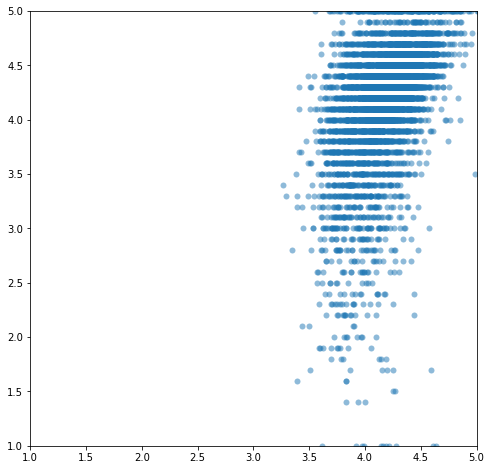

In [93]:
plt.figure(figsize=(8, 8))
sns.scatterplot(stack_prediction, y_data.values, linewidth=0, alpha=0.5)
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.show()

# STEP 13. 제출

In [94]:
submission = pd.DataFrame(columns=['Id', 'Rating'])
submission['Id'] = test.index
submission['Rating'] = np.clip(final_test_pred, 1, 5)
submission.head()

,Id,Rating
0,5617,4.150839
1,5618,3.910072
2,5619,3.847373
3,5620,4.068044
4,5621,4.222778


In [95]:
submission.to_csv('submission.csv', index=False)

### 제출본

* (local, public, private)
* 0.478631, 0.57332, ?
* 0.479858, 0.57478, ?